In [2]:
import tensorflow as tf
import tensorflow_quantum as tfq

from tensorflow.keras import datasets, layers, models

import cirq
import sympy
import numpy as np
import collections

# visualization tools
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

## Load Dataset

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 60000
Number of original test examples: 10000


In [4]:
x_train= tf.cast(x_train, tf.float32)
x_test=tf.cast(x_test, tf.float32)

x_train = tf.image.resize(x_train[:], (10,10)).numpy()
x_test = tf.image.resize(x_test[:], (10,10)).numpy()

y_train = y_train[:]
y_test = y_test[:]

5


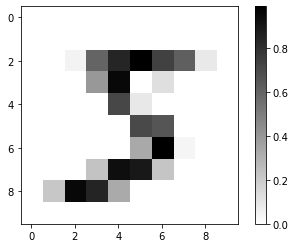

In [5]:
print(y_train[0])
fig = plt.figure()
plt.imshow(x_train[0, :, :, 0], cmap='gray_r')
plt.colorbar()
fig.savefig('sample', dpi=300)

## CNN

In [6]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

cnn_model = models.Sequential()

cnn_model.add(layers.Conv2D(8, (2, 2), activation='relu', input_shape=(width, height, 1)))
#model.add(layers.MaxPooling2D((2, 2)))
#model.add(layers.Conv2D(16, (2, 2), activation='relu'))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(32, activation='relu'))
cnn_model.add(layers.Dense(10, activation='softmax'))

In [7]:
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 8)           40        
                                                                 
 flatten (Flatten)           (None, 648)               0         
                                                                 
 dense (Dense)               (None, 32)                20768     
                                                                 
 dense_1 (Dense)             (None, 10)                330       
                                                                 
Total params: 21,138
Trainable params: 21,138
Non-trainable params: 0
_________________________________________________________________


In [8]:
cnn_model.compile(optimizer=tf.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

cnn_history = cnn_model.fit(x_train, y_train, steps_per_epoch=500,
                        validation_data=(x_test, y_test), 
                        epochs=50, batch_size=5)

Epoch 1/50
500/500 [==============================] - 6s 10ms/step - loss: 1.0706 - accuracy: 0.6808 - val_loss: 0.6268 - val_accuracy: 0.8120
Epoch 2/50
500/500 [==============================] - 5s 9ms/step - loss: 0.5049 - accuracy: 0.8520 - val_loss: 0.4197 - val_accuracy: 0.8767
Epoch 3/50
500/500 [==============================] - 5s 10ms/step - loss: 0.4494 - accuracy: 0.8648 - val_loss: 0.3567 - val_accuracy: 0.8968
Epoch 4/50
500/500 [==============================] - 4s 8ms/step - loss: 0.4267 - accuracy: 0.8704 - val_loss: 0.3925 - val_accuracy: 0.8811
Epoch 5/50
500/500 [==============================] - 5s 10ms/step - loss: 0.3763 - accuracy: 0.8888 - val_loss: 0.3231 - val_accuracy: 0.9005
Epoch 6/50
500/500 [==============================] - 5s 10ms/step - loss: 0.3385 - accuracy: 0.8976 - val_loss: 0.3397 - val_accuracy: 0.9011
Epoch 7/50
500/500 [==============================] - 5s 10ms/step - loss: 0.3186 - accuracy: 0.8984 - val_loss: 0.2962 - val_accuracy: 0.9120
E

## QCNN

In [10]:
class QConv(tf.keras.layers.Layer):
    def __init__(self, filter_size, depth, activation=None, name=None, kernel_regularizer=None, **kwangs):
        super(QConv, self).__init__(name=name, **kwangs)
        self.filter_size = filter_size
        self.depth = depth
        self.learning_params = []
        self.QCNN_layer_gen()
        # self.circuit_tensor = tfq.convert_to_tensor([self.circuit])
        self.activation = tf.keras.layers.Activation(activation)
        self.kernel_regularizer = kernel_regularizer

    def _next_qubit_set(self, original_size, next_size, qubits):
        step = original_size // next_size
        qubit_list = []
        for i in range(0, original_size, step):
            for j in range(0, original_size, step):
                qubit_list.append(qubits[original_size*i + j])
        return qubit_list

    def _get_new_param(self):
        """
        return new learnable parameter
        all returned parameter saved in self.learning_params
        """
        new_param = sympy.symbols("p"+str(len(self.learning_params)))
        self.learning_params.append(new_param)
        return new_param
    
    def _QConv(self, step, target, qubits):
        """
        apply learnable gates each quantum convolutional layer level
        """
        yield cirq.CZPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
        yield cirq.CXPowGate(exponent=self._get_new_param())(qubits[target], qubits[target+step])
    
    def QCNN_layer_gen(self):
        """
        make quantum convolutional layer in QConv layer
        """
        pixels = self.filter_size**2
        # filter size: 2^n only for this version!
        if np.log2(pixels) % 1 != 0:
            raise NotImplementedError("filter size: 2^n only available")
        cirq_qubits = cirq.GridQubit.rect(self.filter_size, self.filter_size)
        # mapping input data to circuit
        input_circuit = cirq.Circuit()
        input_params = [sympy.symbols('a%d' %i) for i in range(pixels)]
        for i, qubit in enumerate(cirq_qubits):
            input_circuit.append(cirq.rx(np.pi*input_params[i])(qubit))
        # apply learnable gate set to QCNN circuit
        QCNN_circuit = cirq.Circuit()
        step_size = [2**i for i in range(np.log2(pixels).astype(np.int32))]
        for step in step_size:
            for target in range(0, pixels, 2*step):
                QCNN_circuit.append(self._QConv(step, target, cirq_qubits))
        # merge the circuits
        full_circuit = cirq.Circuit()
        full_circuit.append(input_circuit)
        full_circuit.append(QCNN_circuit)
        self.circuit = full_circuit # save circuit to the QCNN layer obj.
        self.params = input_params + self.learning_params
        self.op = cirq.Z(cirq_qubits[0])
        
    def build(self, input_shape):
        self.width = input_shape[1]
        self.height = input_shape[2]
        self.channel = input_shape[3]
        self.num_x = self.width - self.filter_size + 1
        self.num_y = self.height - self.filter_size + 1
        
        self.kernel = self.add_weight(name="kenel", 
                                      shape=[self.depth, 
                                             self.channel, 
                                             len(self.learning_params)],
                                     initializer=tf.keras.initializers.glorot_normal(),
                                     regularizer=self.kernel_regularizer)
        self.circuit_tensor = tfq.convert_to_tensor([self.circuit] * self.num_x * self.num_y * self.channel)
    
    def call(self, inputs):
        # input shape: [N, width, height, channel]
        # slide and collect data
        stack_set = None
        for i in range(self.num_x):
            for j in range(self.num_y):
                slice_part = tf.slice(inputs, [0, i, j, 0], [-1, self.filter_size, self.filter_size, -1])
                slice_part = tf.reshape(slice_part, shape=[-1, 1, self.filter_size, self.filter_size, self.channel])
                if stack_set == None:
                    stack_set = slice_part
                else:
                    stack_set = tf.concat([stack_set, slice_part], 1)  
        # -> shape: [N, num_x*num_y, filter_size, filter_size, channel]
        stack_set = tf.transpose(stack_set, perm=[0, 1, 4, 2, 3])
        # -> shape: [N, num_x*num_y, channel, filter_size, fiter_size]
        stack_set = tf.reshape(stack_set, shape=[-1, self.filter_size**2])
        # -> shape: [N*num_x*num_y*channel, filter_size^2]
        
        # total input citcuits: N * num_x * num_y * channel
        circuit_inputs = tf.tile([self.circuit_tensor], [tf.shape(inputs)[0], 1])
        circuit_inputs = tf.reshape(circuit_inputs, shape=[-1])
        tf.fill([tf.shape(inputs)[0]*self.num_x*self.num_y, 1], 1)
        outputs = []
        for i in range(self.depth):
            controller = tf.tile(self.kernel[i], [tf.shape(inputs)[0]*self.num_x*self.num_y, 1])
            outputs.append(self.single_depth_QCNN(stack_set, controller, circuit_inputs))
            # shape: [N, num_x, num_y] 
            
        output_tensor = tf.stack(outputs, axis=3)
        output_tensor = tf.math.acos(tf.clip_by_value(output_tensor, -1+1e-5, 1-1e-5)) / np.pi
        # output_tensor = tf.clip_by_value(tf.math.acos(output_tensor)/np.pi, -1, 1)
        return self.activation(output_tensor)
    
    def single_depth_QCNN(self, input_data, controller, circuit_inputs):
        """
        make QCNN for 1 channel only
        """
        # input shape: [N*num_x*num_y*channel, filter_size^2]
        # controller shape: [N*num_x*num_y*channel, len(learning_params)]
        input_data = tf.concat([input_data, controller], 1)
        # input_data shape: [N*num_x*num_y*channel, len(learning_params)]
        QCNN_output = tfq.layers.Expectation()(circuit_inputs, 
                                               symbol_names=self.params,
                                               symbol_values=input_data,
                                               operators=self.op)
        # QCNN_output shape: [N*num_x*num_y*channel]
        QCNN_output = tf.reshape(QCNN_output, shape=[-1, self.num_x, self.num_y, self.channel])
        return tf.math.reduce_sum(QCNN_output, 3)

In [11]:
width = np.shape(x_train)[1]
height = np.shape(x_train)[2]

qcnn_model = models.Sequential()


qcnn_model.add(QConv(filter_size=2, depth=8, activation='relu', 
                     name='qconv1', input_shape=(width, height, 1)))
#model.add(layers.Conv2D(16, (2, 2), activation='relu'))
qcnn_model.add(layers.Flatten())
qcnn_model.add(layers.Dense(32, activation='relu'))
qcnn_model.add(layers.Dense(10, activation='softmax'))

In [12]:
qcnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 qconv1 (QConv)              (None, 9, 9, 8)           48        
                                                                 
 flatten_1 (Flatten)         (None, 648)               0         
                                                                 
 dense_2 (Dense)             (None, 32)                20768     
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 21,146
Trainable params: 21,146
Non-trainable params: 0
_________________________________________________________________


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


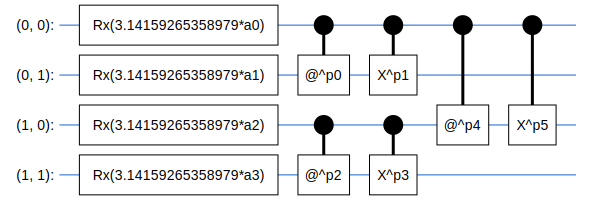

In [13]:
SVGCircuit(QConv(filter_size=2, depth=0, activation='relu').circuit)

In [20]:
qcnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

qcnn_history = qcnn_model.fit(x_train, y_train, steps_per_epoch=50,
                        validation_data=(x_test, y_test), 
                        epochs=5, batch_size=5)

Epoch 1/5
50/50 [==============================] - 205s 4s/step - loss: 0.5546 - accuracy: 0.8320 - val_loss: 0.4491 - val_accuracy: 0.8657
Epoch 2/5
50/50 [==============================] - 221s 4s/step - loss: 0.4059 - accuracy: 0.8600 - val_loss: 0.4456 - val_accuracy: 0.8671
Epoch 3/5
50/50 [==============================] - 226s 5s/step - loss: 0.5728 - accuracy: 0.8320 - val_loss: 0.4296 - val_accuracy: 0.8739
Epoch 4/5
50/50 [==============================] - 242s 5s/step - loss: 0.4518 - accuracy: 0.8760 - val_loss: 0.4431 - val_accuracy: 0.8706
Epoch 5/5
50/50 [==============================] - 231s 5s/step - loss: 0.4596 - accuracy: 0.8560 - val_loss: 0.4467 - val_accuracy: 0.8673
